In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import hbar, e, electron_mass

In [2]:
#length scale for the problem
l0 = 0.276

In [3]:
def square_potential(width, V0, x):
    #find the value of the potential V(x) for the square potential
    if -width / 2 <= x and x <= width  / 2: #if x is within the region of the potential
        return V0 #then we return the potential
    else: #otherwise the potential is zero
        return 0

In [4]:
def k_func(x, potential, width, V0, E):
    #return the value of k, which is a parameter in the numerov method
    return 2*(E - potential(width = width, V0 = V0, x = x))

In [5]:
def get_ks(xs, dx, potential, width, V0, E):
    #calculate all the possible k values for the system
    #number of k points is x_num + 2 because we have a k value for each positions but we have also a k for both of the initial psi states that we know (at width/2 and 
    #at width/2+dx)
    
    #collect k values here
    ks = []
    
    #add the k values for the two initial states
    ks.append(k_func(x = xs[-1]+2.*dx, potential = potential, width = width, V0 = V0, E = E)) #width/2+dx
    ks.append(k_func(x = xs[-1]+dx, potential = potential, width = width, V0 = V0, E = E)) #width
    
    #now iterate through the position values backwards so that ks contain the k values for decreasing position values
    for x in xs[::-1]:
        #add the k value to the list
        ks.append(k_func(x = x, potential = potential, width = width, V0 = V0, E = E))
    
    #make a numpy array out of this 
    ks = np.array(ks)
    
    #return the ks
    return ks

In [6]:
def iteration(psis, ks, dx):
    #carry out one iteration of the numerov method
    
    #obtain the current state of the method
    n = len(psis) #current number of states that we already obtained
    
    #obtain the k parameters for the 3 states
    kn = ks[n-1]
    kn_p = ks[n-2]
    kn_m = ks[n]
    
    #calculate the new state using the numerov method
    lhs = 2*(1 - 5*dx*dx*kn/(12))*psis[n-1] - (1 + dx*dx*kn_p/(12))*psis[n-2]
    psi_np = lhs /  ((1 + dx*dx*kn_m/(12)))

    #add the new psi state to the list and then return the list
    psis.append(psi_np)
    return psis

In [7]:
def q_func(E):
    #get the value of the wavevector for the initial state
    return np.sqrt(2*E)

In [8]:
def numerov(psis, ks, dx, x_num):
    #do the whole numerov method and obtain the wavefunction
    for i in range(x_num+1):
        psis = iteration(psis = psis, ks = ks, dx = dx)
    return np.array(psis)[::-1]

In [9]:
def findAB(E, dx, psi0, psi_m):
    #find the coefficients A and B so that we can calculate the reflectance and transmittance 
    q = q_func(E)
    A = (psi_m-psi0*np.exp(-1.j* q * dx )) / (np.exp(+1.j*q * dx) - np.exp(-1.j*q*dx) )
    B = psi0-A
    return A, B

In [10]:
def scattering(E, potential, width, V0, x_num):
    #do the whole previous stuff for a given energy value
    
    #define the positions in the systems
    dx = width / x_num #dx is defined in this way
    xs = np.arange(-width/2-dx, width/2, dx) / l0 #lets make the possible position values like this
    dx /= l0 #but we need everything in units of l0 
    width /=l0
    
    #obtain all the k values 
    ks = get_ks(xs = xs, dx = dx, potential = potential, width = width, V0 = V0, E = E)
    
    #define the initial psi values
    psis = [np.exp(-1j*q_func(E)*dx),1]
    
    #carry out the numerov method and obtain the wavefunction
    psis_final = numerov(psis = psis, ks = ks, dx = dx, x_num = x_num)
    
    #calculate the coefficients
    A,B = findAB(E = E, dx = dx, psi0 = psis_final[1], psi_m = psis_final[0])
    
    #find the reflectance and the transmittance
    R = (np.abs(B)**2)/(np.abs(A)**2)
    T = 1/(np.abs(A)**2)
    #return their values
    return R,T

In [11]:
def multi_scattering(Es, potential, width, V0, x_num):
    #repeat the the numerov method for different energy values
    
    #list for the R and T values
    Rs = []
    Ts = []
    
    #for every energy value
    for E in Es:
        #get the R and T values
        R, T =  scattering(E = E, potential = potential, width = width, V0 = V0, x_num = x_num)
        
        #add them to the lists
        Rs.append(E)
        Ts.append(T)

    #create numpy arrays out of the lists
    Rs = np.array(Rs)
    Ts = np.array(Ts)

    #return the values
    return Rs, Ts

In [12]:
def pot_strength(width,V0):
    #calculate the strength of the potential
    return np.sqrt(2*e*V0*electron_mass)*width*1e-9/hbar

In [13]:
def get_pot_width(pot_strength,V0):
    #calculate the width of the potential for a given 
    return pot_strength*hbar/np.sqrt(2*electron_mass*e*V0)/1e-9 

In [14]:
#height of the potential
V0 = 2

#possible energy values
Es = np.linspace(0.01,3.,200)*V0

In [15]:
width = get_pot_width(7,V0) #get width for this value of the height for potential strength 7
print(width)
x_num = 1000
#and carry out the numerov method for the energies
Rs, Ts = multi_scattering(Es = Es, potential = square_potential, width = width, V0 = V0, x_num = x_num)

0.966149894404559


In [16]:
#repeat for other potential strength values as well
width = get_pot_width(3,V0)
print(width)
x_num = 1000

Rs2, Ts2 = multi_scattering(Es = Es, potential = square_potential, width = width, V0 = V0, x_num = x_num)

0.4140642404590968


In [17]:
#and again do it for other values as well
width = get_pot_width(1,V0)
print(width)
x_num = 1000

Rs3, Ts3 = multi_scattering(Es = Es, potential = square_potential, width = width, V0 = V0, x_num = x_num)

0.1380214134863656


In [18]:
#calculate the analytical curves (now using SI)
def analytical_curve(E,V0,width):
    a = width * 1e-9
    
    if E-V0 >= 0 : #classical regime
        k = np.sqrt(2*electron_mass*e*(E-V0))/ hbar
        
        den = 1 + V0**2 / (4 * E * (E-V0) ) * (np.sin(k*a))**2
        
    else:
        k = np.sqrt(2*electron_mass*e*(V0-E))/ hbar
        
        den = 1 + V0**2 / (4 * E * (V0-E) ) * (np.sinh(k*a))**2
        
    return np.real(1/den)

In [19]:
#get the analytical values for potential strength 7
ac = []
width = get_pot_width(7,V0)
print(width)

for E in Es:
    ac.append(analytical_curve(E = E, V0 = V0, width = width))
    
ac = np.array(ac)

0.966149894404559


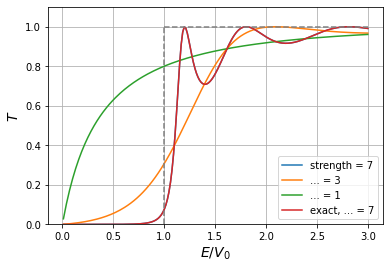

In [20]:
fig = plt.figure()
plt.plot(Es/V0,Ts, label = "strength = 7")
plt.plot(Es/V0,Ts2, label = "... = 3")
plt.plot(Es/V0,Ts3, label = "... = 1")

plt.plot(Es/V0, ac, label = "exact, ... = 7")
plt.xlabel(r"$E/V_0$", fontsize = 14)
plt.ylabel(r"$T$", fontsize = 14)
plt.ylim(0,1.1)
plt.plot([1,1],[0,1], "--", color = "grey")
plt.plot([1,3],[1,1], "--", color = "grey")
plt.legend()
plt.grid()
plt.show()

The peaks from the numerical simulation coincide with the exact results.

In [21]:
def gaussian(x, width):
    #return gaussian curve 
    a = width / 2
    return np.exp( -1 * x**2 / ( 2 * (a/4)**2 ) )

In [22]:
def gaussian_potential(width, V0, x):
    #if we are within the range of the potential then return the corresponding point from the gaussian, otherwise return 0
    if -width / 2 <= x and x <= width  / 2: 
        return gaussian(x = x, width = width)*V0 #scale the gaussian with V0 amplitude
    else: #otherwise the potential is zero
        return 0

In [23]:
#repeat the whole thing again for this other potential
V0 = 2
Es = np.linspace(0.01,3.,200)*V0

In [24]:
width = get_pot_width(7,V0)
print(width)
x_num = 1000

Rs, Ts = multi_scattering(Es = Es, potential = gaussian_potential, width = width, V0 = V0, x_num = x_num)

0.966149894404559


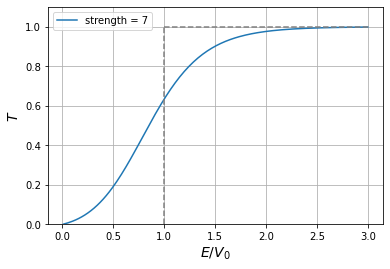

In [25]:
fig = plt.figure()
plt.plot(Es/V0,Ts, label = "strength = 7")

plt.xlabel(r"$E/V_0$", fontsize = 14)
plt.ylabel(r"$T$", fontsize = 14)
plt.ylim(0,1.1)
plt.plot([1,1],[0,1], "--", color = "grey")
plt.plot([1,3],[1,1], "--", color = "grey")
plt.legend()
plt.grid()
plt.show()

Seems like that the resonances are characteristic to the square well and for the gaussian curve we don't have something like this.